### Aplicando método de otimização para ajuste do modelo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# sigmoid.py (https://github.com/fpelogia/epid-models/blob/master/sigmoid.py)
from sigmoid import f_t, deriv_f_t 
# new_wave.py (https://github.com/fpelogia/epid-models/blob/master/new_wave.py)
from new_wave import new_wave_detection, filter_data, forward_euler 

In [2]:
#import data
data = pd.read_csv("Datasets/jerusalem.csv")  
acc_n_cases = data.total_confirmed
normalized_acc_n_cases = data.total_confirmed / max(data.total_confirmed)
t = np.linspace(0, len(acc_n_cases), len(acc_n_cases))

# for the "one wave" tests
model = f_t
n_days = 90 

### 1 - Uma onda epidemiológica

#### 1.1 - Definindo o problema de otimização
Definiremos uma função para descrever a perda do modelo em relação aos dados reais. Ela será a função objetivo do problema de minimização.

Seja o vetor x de parâmetros:
$$x = [A\quad \nu\quad \delta\quad t_p]^T$$
Problema de otimização descrito no artigo da ASOC:
$$min \sum_{t=0}^{t=t_{end}} t(y_t(t) - y_m(t, x))^2$$ 

$$\textrm{s.t.}\quad A \geq 0,\\\quad\quad\ \nu > 0,\\\quad\quad\ \delta > 0,\\\quad\quad\  t_p \geq 0$$ 

Ao invés de utilizarmos a função objetivo apresentada (ITSE), _utilizaremos a Mean Squared Error_ (MSE), que pode ser formulada da seguinte forma:
$$MSE(x) = \sum_{t=0}^{t=t_{end}} (y_t(t) - y_m(t, x))^2$$

A otimização será feita em duas etapas:
- 1 - Otimizar uma sigmoide simétrica ($\nu$ = 1)
- 2 - Otimizar uma sigmoide assimétrica, utilizando o ponto ótimo da etapa 1 como ponto inicial.

Para a implementação, estamos utilizando a função [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
) do pacote do otimização da biblioteca Scipy. O método de otimização utilizado é o _Sequential Least Squares Programming_ (SLSQP).

![](https://i.imgur.com/4goNTaQ.png)

A função em questão também permite a utilização de diversos outros métodos de otimização.

![](https://i.imgur.com/m2hO3lL.png)



In [3]:
n_sig = 1
sig_params = []
def model(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += f_t(t[:n_days], A, tp, delta, nu)
    return res

# Integral Time Square Error (ITSE)
def ITSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_n_cases[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return np.sum(t[:n_days]*(y_t - y_m)**2)

# Mean Squared Error (MSE)
def MSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_n_cases[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

def loss_f(x, lf):
    if(lf == 'MSE'):
        return MSE(x)
    elif(lf == 'ITSE'):
        return ITSE(x)
    else:
        return MSE(x)


def loss_f_sym(x, lf):
    # nu = 1 (symmetric sigmoid)
    if(lf == 'MSE'):
        return MSE([x[0], x[1], x[2], 1]) 
    elif(lf == 'ITSE'):
        return ITSE([x[0], x[1], x[2], 1]) 
    else:
        return MSE([x[0], x[1], x[2], 1]) 
    

# Inequality contraints need to return f(x), where f(x) >= 0
def constr1(x):
    # A >= 0
    return x[0]
def constr2(x):
    # tp >= 0
    return x[1]
def constr3(x):
    # delta = 0.1
    return x[2] - 1e-1
def constr4(x):
    # nu > 0.1
    return x[3] - 1e-1

con1 = {'type':'ineq', 'fun':constr1}
con2 = {'type':'ineq', 'fun':constr2}
con3 = {'type':'ineq', 'fun':constr3}
con4 = {'type':'ineq', 'fun':constr4}     
cons = [con1, con2, con3, con4] 

     fun: 7155.451696264072
     jac: array([-0.00018311, -0.00305176,  0.00146484,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 152
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([3.13551538e+03, 3.14934412e+01, 6.70161327e+00, 1.00000000e+00])


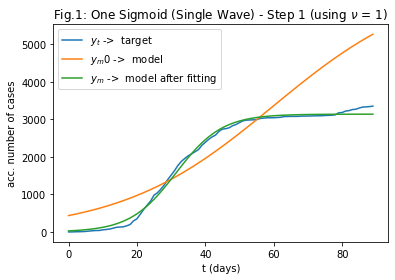

In [4]:
# Step 1 - Optimize a symmetric sigmoid (nu = 1)
y_t = acc_n_cases[:n_days]
A0 = 2*max(y_t)
tp0 = (2/3)*len(y_t)
delta0 = (1/4)*len(y_t)
nu0 = 1
x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.1: One Sigmoid (Single Wave) - Step 1 (using $\\nu$ = 1)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model')
plt.plot(y_m, label='$y_m$ ->  model after fitting')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()

     fun: 2798.2112128336125
     jac: array([ 2.74658203e-04, -5.45654297e-02, -1.64794922e-02,  1.82436478e+03])
 message: 'Optimization terminated successfully'
    nfev: 62
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([3.18911176e+03, 2.78316267e+01, 9.69631707e+00, 1.00000000e-01])


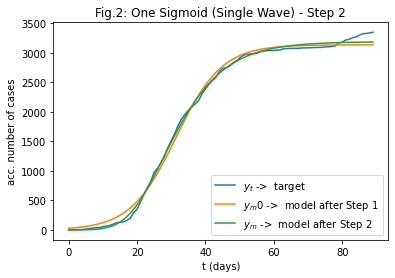

In [5]:
# Step 2 - Optimize an assymmetric sigmoid
# using optimal values of step 1 as the starting point
[A0, tp0, delta0, nu0] = sol.x

x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_t = acc_n_cases[:n_days]
y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.2: One Sigmoid (Single Wave) - Step 2')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
plt.plot(y_m, label='$y_m$ ->  model after Step 2')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()

### 2 - Múltiplas ondas epidemiológicas
Para fazer o ajuste do modelo para dados de N ondas epidemiológicas, utilizamos um modelo que envolve a soma de N sigmoides ($f(t)$).

![](https://i.imgur.com/YixfYwH.png)

[Escrever aqui um textinho mais elaborado documentando a lógica para múltiplas ondas]

In [6]:
a = []
a.append([1, 2, 3, 4])
a.append([5, 6, 7, 8])
print(a)
print(a[0])

[[1, 2, 3, 4], [5, 6, 7, 8]]
[1, 2, 3, 4]


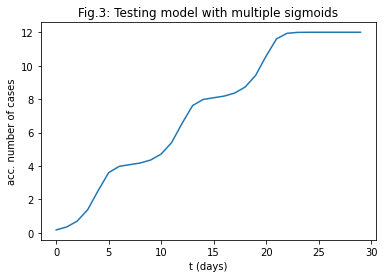

In [7]:
# Testing model for multiple sigmoids
n_days = 30
n_sig = 3
sig_params = [
    [4, 4, 0.5, 2.9],
    [4, 12, 0.5, 2.9]
]
[A, tp, delta, nu] = [4, 20, 0.5, 2.9]
plt.title('Fig.3: Testing model with multiple sigmoids')
plt.plot(model(t[:n_days], A, tp, delta, nu))
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.show()

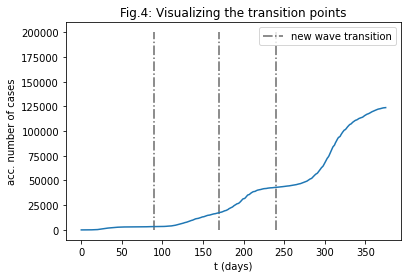

In [8]:
fig = plt.figure()
plt.plot(acc_n_cases)
# Defini manualmente, por enquanto...
# pelo new_wave.py daria x_t [11, 101, 167, 254]
x_nw = [90, 170, 240]
plt.title('Fig.4: Visualizing the transition points')
plt.vlines(x_nw, 0, 200e3, colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()


========= Wave nr 1 =========
From 0 to  90
Step 1
     fun: 7155.451696264072
     jac: array([-0.00018311, -0.00305176,  0.00146484,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 152
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([3.13551538e+03, 3.14934412e+01, 6.70161327e+00, 1.00000000e+00])
Step 2
     fun: 2798.2112128336125
     jac: array([ 2.74658203e-04, -5.45654297e-02, -1.64794922e-02,  1.82436478e+03])
 message: 'Optimization terminated successfully'
    nfev: 62
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([3.18911176e+03, 2.78316267e+01, 9.69631707e+00, 1.00000000e-01])


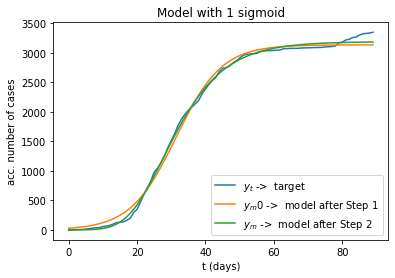

========= Wave nr 2 =========
From 0 to  170
Step 1
     fun: 28261.0258554951
     jac: array([ 0.00219727, -0.26977539,  0.03710938,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 114
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([1.46987827e+04, 1.40036664e+02, 1.19773556e+01, 1.00000000e+00])
Step 2


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 6770.345398079975
     jac: array([ 5.49316406e-04, -1.09985352e-01, -1.62353516e-02,  3.02575488e+03])
 message: 'Optimization terminated successfully'
    nfev: 124
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([1.77274825e+04, 1.37992854e+02, 2.23670528e+01, 1.00000000e-01])


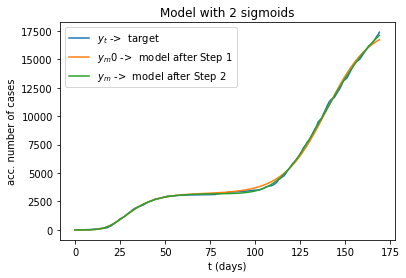

========= Wave nr 3 =========
From 0 to  240
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 35637.36612881776
     jac: array([ 0.00146484, -0.00732422,  0.00585938,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 99
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([2.21916627e+04, 1.99629569e+02, 8.49837653e+00, 1.00000000e+00])
Step 2
     fun: 27612.77354288116
     jac: array([-0.00708008,  0.06933594, -0.33984375, -5.65625   ])
 message: 'Optimization terminated successfully'
    nfev: 89
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([2.26104567e+04, 1.98148061e+02, 1.02008051e+01, 6.03984006e-01])


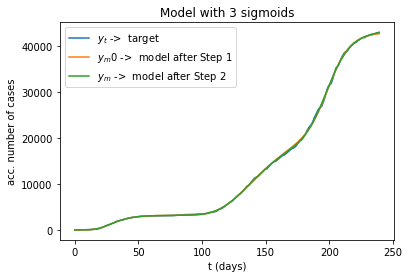

========= Wave nr 4 =========
From 0 to  376
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 518788.59077812405
     jac: array([-0.05859375,  1.66796875, -0.390625  ,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 419
     nit: 72
    njev: 71
  status: 0
 success: True
       x: array([7.83261101e+04, 3.11448485e+02, 1.37524490e+01, 1.00000000e+00])
Step 2
     fun: 518788.59077812405
     jac: array([-1.1718750e-02,  1.6796875e+00, -3.1250000e-01,  7.2003809e+05])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 5
    njev: 1
  status: 0
 success: True
       x: array([7.83261101e+04, 3.11448485e+02, 1.37524490e+01, 1.00000000e+00])


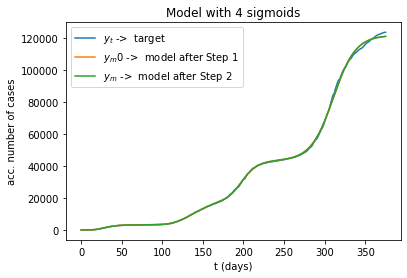

In [9]:
n_sig = 1
sig_params = []
for i in range(len(x_nw) + 1):
    if(i == len(x_nw)):
        n_days = len(acc_n_cases)
    else:
        n_days = x_nw[i]
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    if(i == 0):
        y_t = acc_n_cases[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 50
        A0 *= 1.2
    # else:
    #     [A0, tp0, delta0, nu0] = sig_params[len(sig_params) - 1]
    #     tp0 = tp0 + 100
    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    y_t = acc_n_cases[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"
    plt.title(f'Model with {n_sig} sigmoid{s}')
    plt.plot(y_t, label='$y_t$ ->  target')
    plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
    plt.plot(y_m, label='$y_m$ ->  model after Step 2')
    plt.xlabel('t (days)')
    plt.ylabel('acc. number of cases')
    plt.legend()
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

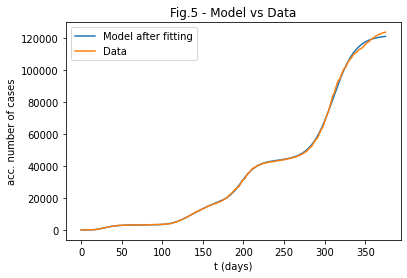

In [10]:
n_sig = 4
plt.title('Fig.5 - Model vs Data')
plt.plot(model(t[:n_days], A, tp, delta, nu), label='Model after fitting')
plt.plot(acc_n_cases[:n_days], label='Data')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()

In [11]:
n_days

376

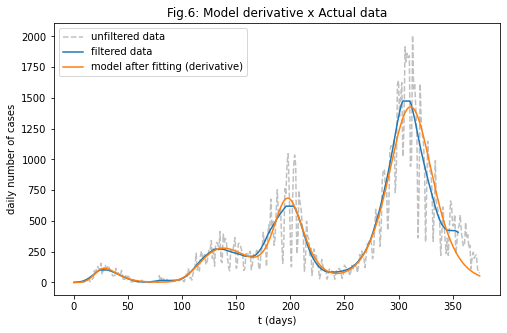

In [12]:
model_der = forward_euler(t[:n_days], 1, y_m[:n_days], 0)
daily_n_cases = forward_euler(t[:n_days], 1, acc_n_cases[:n_days], 0)

plt.figure(figsize=(8, 5))
plt.title('Fig.6: Model derivative x Actual data')
plt.plot(daily_n_cases, label="unfiltered data", c='silver', linestyle='dashed')
plt.plot(filter_data(daily_n_cases), label="filtered data")
plt.plot(model_der, label='model after fitting (derivative)')
plt.xlabel('t (days)')
plt.ylabel('daily number of cases')
plt.legend()
plt.show()

#### ===== Rascunho (testes para melhor entendimento) =====

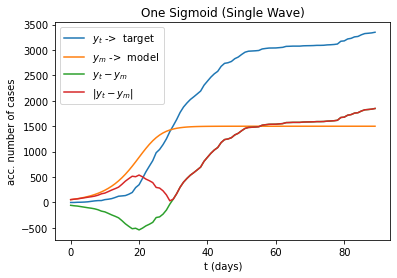

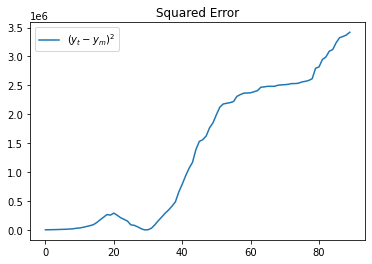

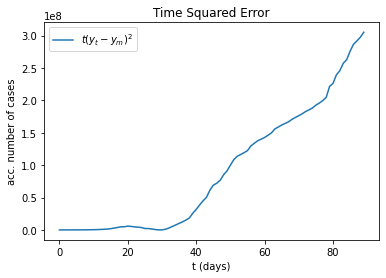

In [13]:
n_sig = 1
n_days = 90
# Initialize model parameters
A = 1500
tp = 20
delta = 3.1
nu = 2.2

y_t = acc_n_cases[:n_days]
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('One Sigmoid (Single Wave)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m, label='$y_m$ ->  model')
plt.plot(y_t - y_m, label='$y_t - y_m$')
plt.plot(abs(y_t - y_m), label='|$y_t - y_m$|')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()
plt.title('Squared Error')
plt.plot((y_t - y_m)**2, label='$(y_t - y_m)^2$')
plt.legend()
plt.show()
plt.title('Time Squared Error')
plt.plot(t[:n_days]*(y_t - y_m)**2, label='$t(y_t - y_m)^2$')
plt.xlabel('t (days)')
plt.ylabel('acc. number of cases')
plt.legend()
plt.show()


In [14]:
# Fazendo testes com múltiplas ondas
# Modelo envolvendo soma de sigmoides assimétricas 
n_sig = 4
x = np.random.rand(4*n_sig)
x

array([0.4614943 , 0.30052117, 0.86785496, 0.6707634 , 0.02429482,
       0.260978  , 0.24896199, 0.1259021 , 0.65048227, 0.38716016,
       0.44622595, 0.94266952, 0.54057866, 0.48050702, 0.76214752,
       0.08298994])

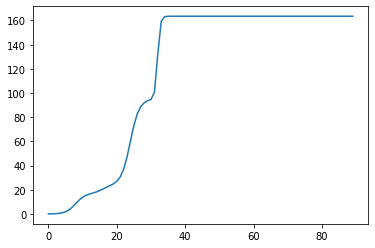

In [15]:
# Antigo... ignorar
n_sig = 4
# inicialização aleatória
x = np.random.rand(4*n_sig)
sigsum = np.zeros(n_days)
for i in range(n_sig):
    A = 1e2*x[i + 0]
    tp = 8*(i+1)
    delta = 2*x[i + 2]
    nu = 1
    sigsum += f_t(t[:n_days], A, tp, delta, nu)
plt.plot(sigsum)
plt.show()